In [4626]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import kernels, GaussianProcessRegressor

if os.getcwd() == '/Users/cd8607/Documents/Fitting_Potential':
    pass
else:
    os.chdir('../')

whe = np.loadtxt('Potentials/W-He-Juslin.table',skiprows=6)[:,1:3]

In [4628]:
class Fit_PairPot():

    def __init__(self, Zi, Zj, order = 4, reg = 1e-4):

        self.Zi = Zi
        self.Zj = Zj

        self.order = order

        # self.mean = 0.5*np.ones((self.order,))
        self.mean = np.zeros((self.order,))
        self.mean = np.linspace(0.5,4, self.order)
        self.sigma = 0.4*np.ones((self.order,))

        # self.amplitude = self.log_normal(np.exp(self.mean -self.sigma**2).reshape(1,-1))[0,0]

        self.reg = 1e-4


    def zbl(self, rij):
     
        e0 = 55.26349406e-4

        const = 1/(4*np.pi*e0)

        a = 0.46850/(self.Zi**0.23 + self.Zj**0.23)	

        x = rij/a

        x = x[:, np.newaxis]

        amplitude = np.array([0.18175, 0.50986, 0.28022, 0.02817])
        exponent = np.array([3.19980, 0.94229, 0.40290, 0.20162])

        phi = np.sum(amplitude * np.exp(-exponent * x), axis=1)
            
        return const*phi*(self.Zi*self.Zj/rij)
    
    def log_normal(self, x):
        
        x_offset = np.clip(x[:,np.newaxis] - self.offset, a_min=0.01, a_max=None)
        
        phi = (1/(x_offset*self.sigma*np.sqrt(2*np.pi)))*np.exp(-(np.log(x_offset)-self.mean)**2/(2*self.sigma**2))

        return phi
    
    def normal(self, x):

        phi = (1/(self.sigma*np.sqrt(2*np.pi)))*np.exp(-(x[:,np.newaxis]-self.mean)**2/(2*self.sigma**2))

        return phi
    
    def normalize(self, rij, pot):

        y_target = pot - self.zbl(rij)

        return y_target.reshape(-1,1)

    def fit(self, x_train, y_train):

        phi = self.normal(x_train)

        self.weights = np.linalg.inv(phi.T@phi + self.reg*np.eye(phi.shape[1]))@(phi.T)@y_train

        return self.weights
    
    
    def loss(self, x_train, y_train):

        phi = self.normal(x_train)

        y_predict = phi@self.weights

        return -np.log(np.linalg.norm(y_train - y_predict)/len(y_train))

    
    def random_sampling(self, n_samples, n_points, x_train, y_train):
        
        sampled_points = np.random.normal(loc = 0, scale = 0.1, size = (n_samples, n_points))

        sampled_loss   = np.zeros((n_samples, ))
        sampled_weights = np.zeros((n_samples, self.order))

        x_knot = np.linspace(0.5, 4, n_points)
        
        for i in range(n_samples):


            sampled_weights[i] = self.fit(x_knot, sampled_points[i])

            sampled_loss[i] = self.loss(x_train, y_train)

        return sampled_weights, sampled_loss, sampled_points



order = 6

inst = Fit_PairPot(74, 2, order, 1e-3)

rand = np.random.randint(low = 0, high = len(whe), size = (10,))

y_target = inst.normalize(whe[rand,0], whe[rand,1])

weights = inst.fit(whe[rand,0], y_target)

print(weights)

[[ 3.78115166e-04]
 [ 1.04164114e-01]
 [-4.09992580e-01]
 [ 7.25183318e-02]
 [-4.16075976e-01]
 [-3.83788973e-02]]


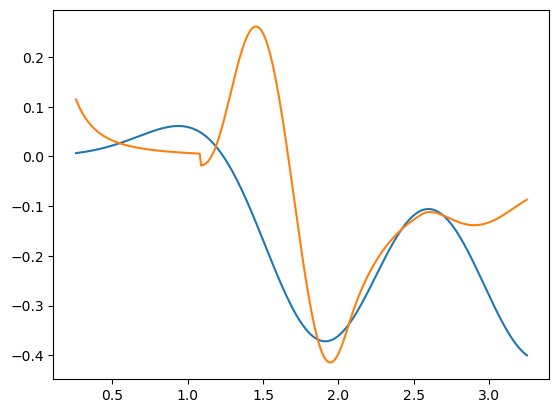

In [4629]:

x = whe[25:,0]

y = inst.normal(x) @ weights

plt.plot(x, y)

plt.plot(x, whe[25:,1] - inst.zbl(whe[25:,0]) )

[ 0.25336455 -0.04315221  0.15415717  0.06984169]


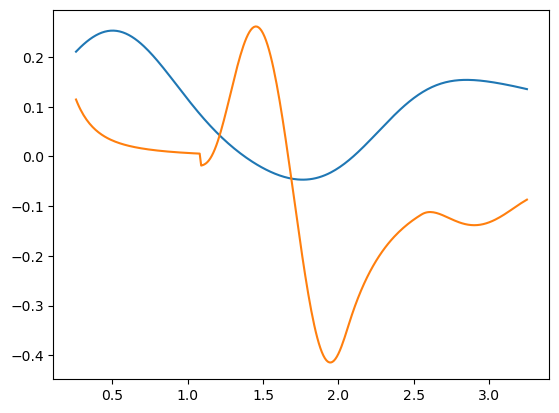

In [4630]:
sampled_weights, sampled_loss, sampled_points = inst.random_sampling(200, 4 , whe[:,0], whe[:,1])

print(sampled_points[sampled_loss.argmax()])

inst.weights = sampled_weights[sampled_loss.argmax()]

y_plt = inst.normal(x)@inst.weights

plt.plot(x, y_plt )

plt.plot(x, whe[25:,1] - inst.zbl(whe[25:,0]) )

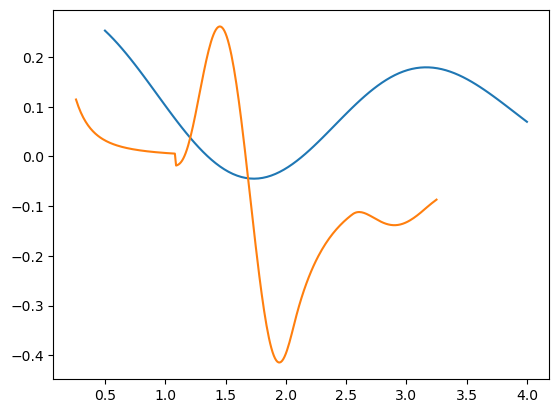

In [4631]:
y_train = sampled_points[sampled_loss.argmax()].reshape(-1,1)
x_knot = np.linspace(0.5, 4, len(y_train)).reshape(-1,1)

gpr = GaussianProcessRegressor().fit(x_knot,y_train)

xplt = np.linspace(0.5,4,100).reshape(-1,1)
yplt = gpr.predict(xplt)

plt.plot(xplt, yplt)
plt.plot(whe[25:,0], whe[25:,1] - inst.zbl(whe[25:,0]) )